In [ ]:
import sys

# Add the directory containing your modules to Python path
sys.path.append('/Users/ellateasell/Research/CodonUsageBias/code')

from lib.aminoacids import AA_TO_CODONS_MULTI_CODON_FAMILIES, AA_1_TO_3
from lib.data_access_helpers import load_elongation_rates, load_rscu_data

In [9]:
elongation_rates = load_elongation_rates()
rscu_data = load_rscu_data("../data/rscu/SP_genes_w21_d40.tsv")

print(elongation_rates.head())

      amino_acid  mean_elongation_rate  median_elongation_rate
Codon                                                         
TGA         STOP                  2.60                    1.42
TAA         STOP                  2.65                    1.49
TAG         STOP                  2.82                    1.31
CGG            R                  3.82                    1.89
CGA            R                  4.02                    2.22


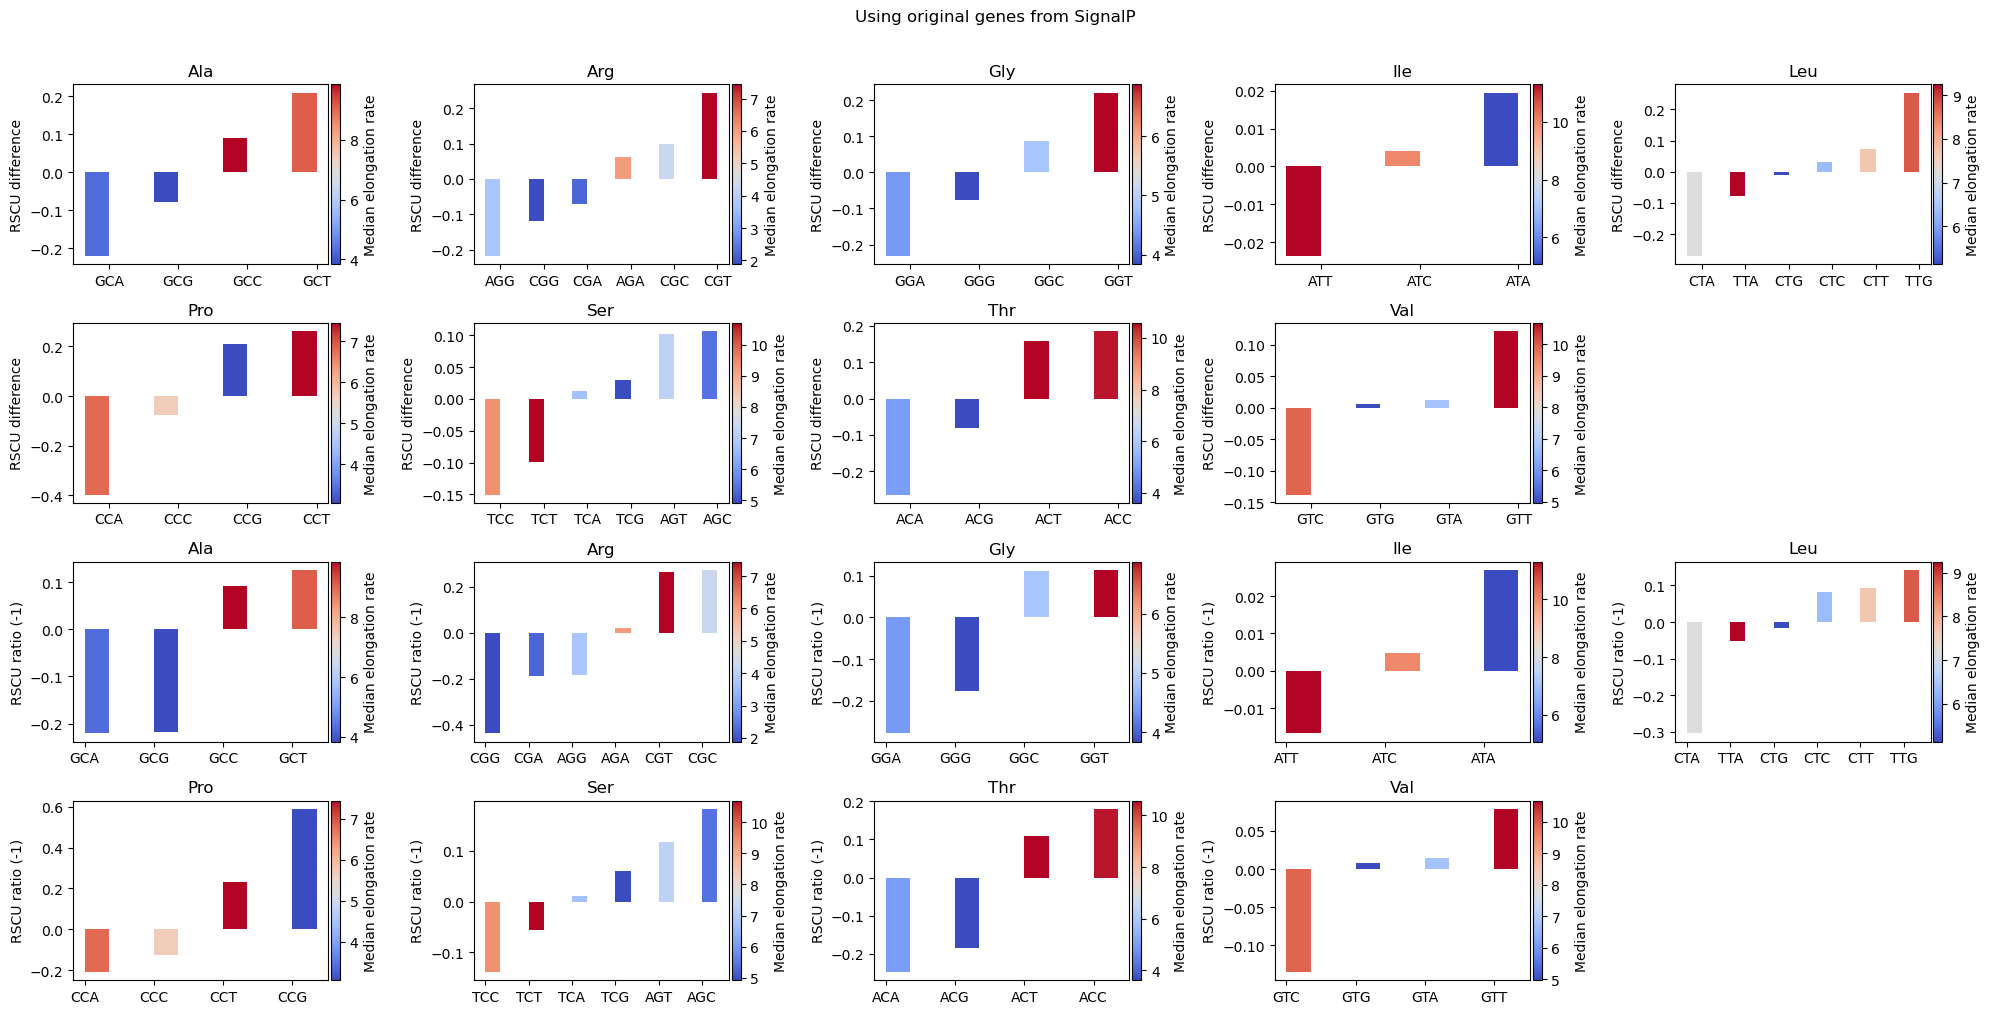

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

fig, axs = plt.subplots(4, 5, figsize=(20, 10))

plt_count = 0
cmap = cm.coolwarm  # colormap

for aa in AA_TO_CODONS_MULTI_CODON_FAMILIES:
    codons = AA_TO_CODONS_MULTI_CODON_FAMILIES[aa]
    n_i = len(codons)
    
    if n_i < 3:
        continue
    
    # initialize arrays
    aa_elongation_rates = np.zeros(n_i)
    aa_rscu_diffs = np.zeros(n_i)
    aa_rscu_ratios = np.zeros(n_i)
    
    for i, codon in enumerate(codons):
        aa_elongation_rates[i] = elongation_rates.loc[codon]['median_elongation_rate']
        aa_rscu_diffs[i] = rscu_data.loc[codon]['window'] - rscu_data.loc[codon]['complement']
        aa_rscu_ratios[i] = rscu_data.loc[codon]['window'] / rscu_data.loc[codon]['complement']
    
    # rank by RSCU difference
    sort_idx_diff = aa_rscu_diffs.argsort()
    ranked_codon_diff = [codons[i] for i in sort_idx_diff]
    ranked_RSCU_diff = [aa_rscu_diffs[i] for i in sort_idx_diff]
    ranked_elg_diff = [aa_elongation_rates[i] for i in sort_idx_diff]
    
    # rank by RSCU ratio
    sort_idx_ratio = aa_rscu_ratios.argsort()
    ranked_codon_ratio = [codons[i] for i in sort_idx_ratio]
    ranked_RSCU_ratio = [aa_rscu_ratios[i] for i in sort_idx_ratio]
    ranked_elg_ratio = [aa_elongation_rates[i] for i in sort_idx_ratio]
    
    # normalize per amino acid for color mapping
    norm_diff = mcolors.Normalize(vmin=min(ranked_elg_diff), vmax=max(ranked_elg_diff))
    norm_ratio = mcolors.Normalize(vmin=min(ranked_elg_ratio), vmax=max(ranked_elg_ratio))
    
    colors_diff = cmap(norm_diff(ranked_elg_diff))
    colors_ratio = cmap(norm_ratio(ranked_elg_ratio))
    
    width = 0.35
    ax_top = axs[plt_count//5, plt_count%5]
    ax_bottom = axs[plt_count//5+2, plt_count%5]
    
    # plot bars
    bars_top = ax_top.bar(np.arange(n_i), ranked_RSCU_diff, width, color=colors_diff)
    bars_bottom = ax_bottom.bar(np.arange(n_i)+width, np.array(ranked_RSCU_ratio)-1, width, color=colors_ratio)
    
    # titles and labels
    ax_top.set_title(AA_1_TO_3[aa])
    ax_bottom.set_title(AA_1_TO_3[aa])
    ax_top.set_ylabel('RSCU difference')
    ax_bottom.set_ylabel('RSCU ratio (-1)')
    ax_top.set_xticks(np.arange(n_i)+width/2)
    ax_bottom.set_xticks(np.arange(n_i)+width/2)
    ax_top.set_xticklabels(ranked_codon_diff)
    ax_bottom.set_xticklabels(ranked_codon_ratio)
    
    # add per-AA colorbars
    sm_diff = cm.ScalarMappable(cmap=cmap, norm=norm_diff)
    sm_diff.set_array([])
    fig.colorbar(sm_diff, ax=ax_top, fraction=0.05, pad=0.01, label='Median elongation rate')
    
    sm_ratio = cm.ScalarMappable(cmap=cmap, norm=norm_ratio)
    sm_ratio.set_array([])
    fig.colorbar(sm_ratio, ax=ax_bottom, fraction=0.05, pad=0.01, label='Median elongation rate')
    
    plt_count += 1

# remove empty axes
fig.delaxes(axs[1,4])
fig.delaxes(axs[3,4])

plt.suptitle('Using original genes from SignalP', y=1.01)
plt.tight_layout()
plt.show()
